In [112]:
# general
import datetime as dt

# data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# plotting
import plotly.plotly as py
import plotly.graph_objs as go

# forecasting
import fbprophet as prophet

# from imports
from plotly.tools import FigureFactory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot  # for offline use
from pandas.io import gbq

from typing import Union, Optional

from query import Query  # custom -> export PYTHONPATH=/path/to/query.py

# run plotly offline and initialize notebook plotting
init_notebook_mode(connected=True)

In [2]:
def read_ts(stationID: Union[int, str], 
            data: Union[list, str], 
            begin: Optional[dt.datetime]=None, 
            end: Optional[dt.datetime]=None,
            query: Union[str, Query, None]=None,
            resample_rule: str="12H") -> tuple:
    """Read timeseries for given data/sensor labels and return in raw/resampled form.
    
    If query is given, use the given query instead of the prebuilt one.
    """
    # sanitizing
    if data:
        data = data if isinstance(data, list) else [data]
    
    if not isinstance(begin, dt.datetime) and not query:
        raise TypeError(f"Expected 'begin' to be datetime.datetime object, but received {type(begin)}.")

    dfs = dict()
    dfs_resampled = dict()

    for sl in data:
        print(f"Working on {sl}-dataset...")
        # create query object
        if not query:
            end = dt.datetime.now(tz=dt.timezone.utc)
            q = Query(SELECT=f"TBTimestamp AS ts, {sl}_Scaled AS {sl}_ts",
                      FROM="`exeter-science-unit.airmonitor.airmonitor`",
                      WHERE=f"UniqueID = {stationID} AND {sl}_Status = 'Valid' AND {sl}_Scaled >= 0" 
                            f" AND TBTimestamp >= '{begin}' AND TBTimestamp <= '{end}'",
                      ORDERBY="ts")
        else:
            q = query

        # read data
        dfs[sl] = gbq.read_gbq(str(q), dialect='standard')

        # transform timestamps to datetime and set index to datetime
        dfs[sl].ts = pd.to_datetime(dfs[sl].ts)
        dfs[sl].index = dfs[sl].ts

        # resample data
        dfs_resampled[sl] = dfs[sl].resample(resample_rule).mean()
        
    return dfs, dfs_resampled


In [3]:
begin = dt.datetime(year=2017, month=6, day=3, tzinfo=dt.timezone.utc)
resample_rule = "12H"
stationID = 131150
texify = {"CO": "$\\mathsf{CO}$",
          "NO": "$\\mathsf{NO}$",
          "NO2": "$\\mathsf{NO}_2$",
          "O3": "$\\mathsf{O}_3$"}

In [4]:
dfs, dfs_resampled = read_ts(stationID=stationID, data=sorted(list(texify.keys())),
                             begin=begin)

Working on CO-dataset...
Working on NO-dataset...
Working on NO2-dataset...
Working on O3-dataset...


In [4]:
T_query = Query(SELECT=f"TBTimestamp AS ts, TEMP_Scaled AS TEMP_ts",
                      FROM="`exeter-science-unit.airmonitor.airmonitor`",
                      WHERE=f"UniqueID = {stationID} AND TEMP_Status = 'Valid'" 
                            f" AND TBTimestamp >= '{begin}' AND TBTimestamp <= '{dt.datetime.now(tz=dt.timezone.utc)}'",
                      ORDERBY="ts")

T_df, T_df_resampled = read_ts(stationID=stationID, data="TEMP", query=T_query)

Working on TEMP-dataset...


## Plotting with Pandas 

Text(0.5, 1.0, 'Station 131150')

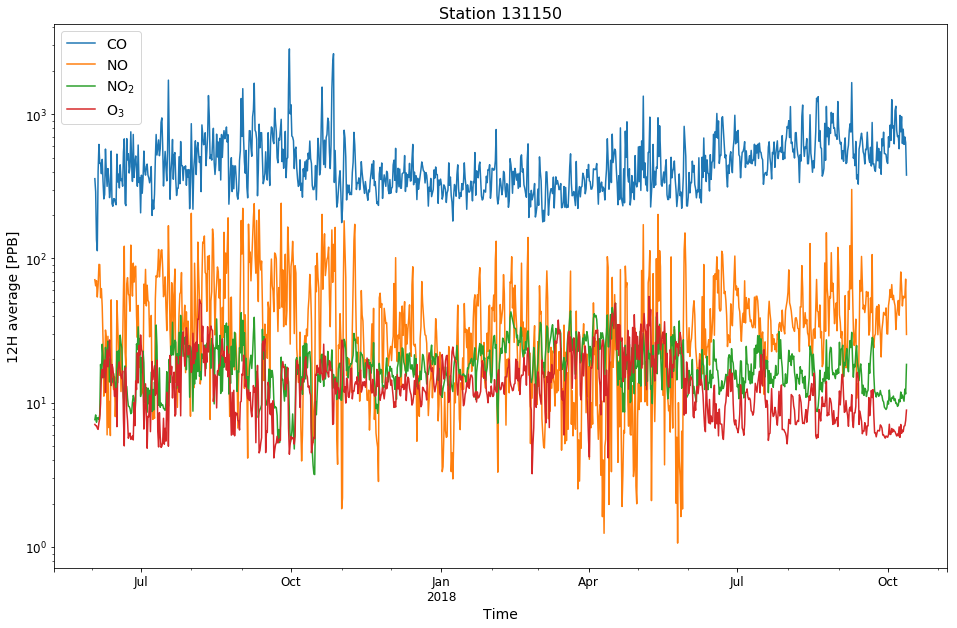

In [45]:
# figure setup
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

# adding lines to the axis
for sl, df in sorted(dfs_resampled.items()):
    df.plot(style='-', ms=5, fontsize=12, ax=ax)

# legend and scale(s)    
ax.legend([texify[key] for key in sorted(list(dfs_resampled.keys()))], fontsize=14)
ax.set_yscale('log')

# cosmetics
ax.set_ylabel(f"{resample_rule} average [PPB]", fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_title(f"Station {stationID}", fontsize=16)


## Plotting with Plotly

In [10]:
data = []
for sl, df in sorted(dfs_resampled.items()):
    data.append(go.Scatter(x=df.index, 
                           y=getattr(df, f"{sl}_ts"),  # get data attribute of DataFrame
                           name=sl))  # latex doesn't work right now for plotly for some reason... 

# setting layout options
layout = go.Layout(showlegend=True, title=f"Station {stationID}", width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule} average [PPB]", 'type': "log"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig)

# Forecasting
a humble approach using Facebook's Prophet package

In [118]:
prophet.Prophet.plot?

In [108]:
# set the size of training data
lim = -1

# Prophet requires columns ds (Date) and y (value) 
train_T = T_df_resampled['TEMP'][:lim]  # set training set
train_T = train_T.rename(columns={'TEMP_ts': 'y'})  # rename column to 'y'
train_T['ds'] = train_T.index  # rename column to 'ds'

# Make the prophet model and fit on the data using default values, but enforcing yearly seasonality
T_prophet = prophet.Prophet(yearly_seasonality=True)
T_prophet.fit(train_T)

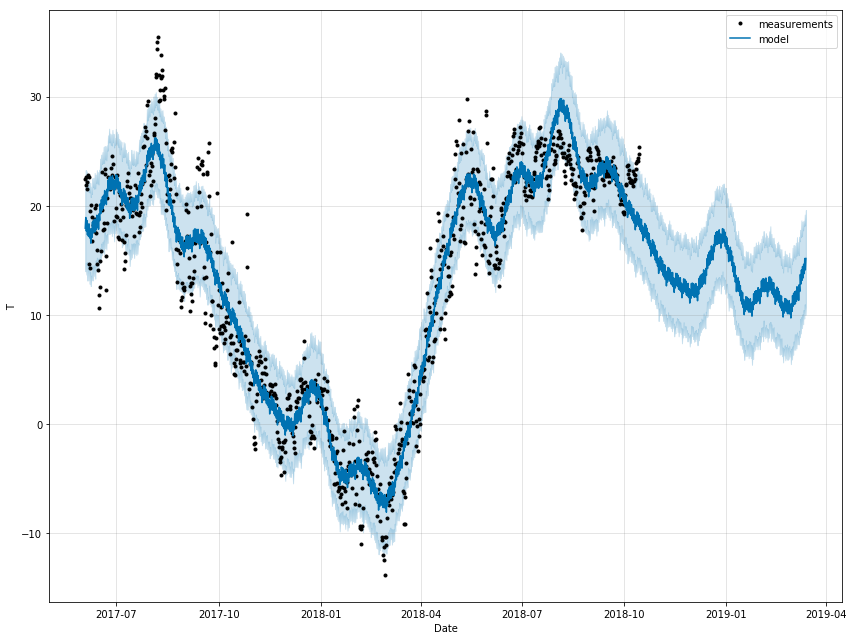

In [119]:
# Make a future dataframe for 2 years
T_forecast = T_prophet.make_future_dataframe(periods=300, freq='12H')

# Make predictions
T_forecast = T_prophet.predict(T_forecast)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

T_prophet.plot(T_forecast, xlabel = 'Date', ylabel = 'T', ax=ax)
ax.legend(['measurements', 'model'])